In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Any, Dict, Iterable, Iterator, List, Optional, Tuple, Union
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import PullData

window_size = 25
formation_window = 24
target_window = 4

GetData = PullData()

GetData.fit(ticker='nvda',
            start_date='1980-01-01',
            end_date='2022-08-04',
            interval='1wk',
            progress=False,
            condition=False,
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=6,
            timeperiod2=12,
            timeperiod3=24,
            export_excel=True
            )

data_prep = GetData.transform()


In [2]:
from transformers import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=25, shuffle=False, debug=False)

data_normalized, Dates = NormalizeData.transform(data_prep)


Initial length of dataframe:  30025
Nr of formations:  1201
New length of dataframe:  30025

Done


In [3]:
from training import SplitData

SplitData = SplitData()

SplitData.fit(split_ratio=0.8, window_size=25, dates=Dates, debug=True)

x_train, x_valid, x_train_x, x_valid_x = SplitData.transform(data_normalized)

# print(data_normalized.shape)


df:   30025
total windows in dataset:  1201.0

total windows of 80.0% train set: 961.0 
total windows of 20% valid set: 240.0 

x_train window 961.0
x_valid window 240.0
Done


In [4]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=25, batch_size=16, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

x_train_tensors


Done


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

In [5]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=25, batch_size=4, train=False, debug=False)

x_valid_tensors, labels = GetTensoredValidDataset.transform(x_valid)
x_valid_tensors


Done


<BatchDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

<b>Model Training</b>

In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss', patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   filepath='./nvda_80_model_checkpoint_recent.h5',
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Model 1

In [7]:
# tf.random.set_seed(7788)

# model = tf.keras.models.Sequential([

#     tf.keras.layers.Conv1D(filters=256, kernel_size=10,
#                       strides=1, padding="same",
#                       activation=tf.nn.selu,
#                       input_shape=[None, 7]),
# #     tf.keras.layers.Conv1D(filters=512, kernel_size=10,
# #                       strides=1, padding="same",
# #                       activation=tf.nn.selu,
# #                       input_shape=[None, 7]),

#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(16, activation=tf.nn.selu),
#     tf.keras.layers.Dense(16, activation=tf.nn.selu),
#     tf.keras.layers.Dense(4, activation=tf.nn.selu),
#     tf.keras.layers.Dense(3, activation=tf.nn.selu), #4
#     tf.keras.layers.Dense(1,activation=tf.nn.relu),
# ])

# #optimizer1 = tf.keras.optimizers.SGD(learning_rate=10e-7, momentum=0.9)
# #optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
# #optimizer3 = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
# #optimizer4 = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')

# optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.0001, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')


# model.compile(loss=sign_penalty,
#               optimizer=optimizer5,
#               )

# model.fit(train_set, epochs=120,callbacks=[callbacks],validation_data=val_dataset)


Model 2

In [8]:
tf.random.set_seed(7788)
np.random.seed(7788)

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=8, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           input_shape=[None, 7]),
    tf.keras.layers.Conv1D(filters=16, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.elu,
                           #input_shape=[None, 7]
                           ),
    tf.keras.layers.Conv1D(filters=32, kernel_size=10,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),
    #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(3, activation=tf.nn.selu),
    tf.keras.layers.Dense(2, activation=tf.nn.selu),
    tf.keras.layers.Dense(1, activation=tf.nn.relu),
])

optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.01, initial_accumulator_value=4, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(x_train_tensors, epochs=120, callbacks=[
          callbacks], validation_data=x_valid_tensors)


Epoch 1/120
61/61 [==============================] - 8s 65ms/step - loss: 0.0369 - val_loss: 0.0280 - lr: 0.0100
Epoch 2/120
61/61 [==============================] - 2s 26ms/step - loss: 0.0292 - val_loss: 0.0260 - lr: 0.0100
Epoch 3/120
61/61 [==============================] - 1s 22ms/step - loss: 0.0272 - val_loss: 0.0247 - lr: 0.0100
Epoch 4/120
61/61 [==============================] - 1s 21ms/step - loss: 0.0259 - val_loss: 0.0238 - lr: 0.0100
Epoch 5/120
61/61 [==============================] - 1s 22ms/step - loss: 0.0248 - val_loss: 0.0228 - lr: 0.0100
Epoch 6/120
61/61 [==============================] - 1s 21ms/step - loss: 0.0239 - val_loss: 0.0221 - lr: 0.0100
Epoch 7/120
61/61 [==============================] - 1s 20ms/step - loss: 0.0232 - val_loss: 0.0218 - lr: 0.0100
Epoch 8/120
61/61 [==============================] - 1s 23ms/step - loss: 0.0226 - val_loss: 0.0212 - lr: 0.0100
Epoch 9/120
61/61 [==============================] - 1s 22ms/step - loss: 0.0221 - val_loss: 0.0

In [9]:
def model_forecast(model, series, window_size, debug):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    if debug == True:
        # This block of code will print out data on which is made prediction
        for item in ds:
            c += 1
            if c < 3:
                print("\n"+str(c) + " prediction:\n ", item)
            else:
                break

    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    forecast2 = np.squeeze(forecast)
    return forecast2


forecast = model_forecast(model, x_valid, window_size=window_size, debug=False)
forecast[:2]


240/240 [==============================] - 2s 4ms/step


array([0.9225807 , 0.86792785], dtype=float32)

In [10]:
pr = x_valid.iloc[:24, :].to_numpy()
pr = np.array([pr])
pr = np.array([pr])
pred = tf.data.Dataset.from_tensor_slices(pr)
predict = model.predict(pred)
print("Raw prediction: ", predict)


1/1 [==============================] - 0s 14ms/step
Raw prediction:  [[0.9225807]]


In [11]:
from transformers import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_valid=x_valid, x_valid_x=x_valid_x, window_size=25, debug=False)

df = ReverseNormalization.transform()
df.shape

Done


(6000, 9)

In [12]:
from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_valid=x_valid)

df1 = GetFinalDataframe.transform(df)
df1.head()


Done


,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime
In,,,,,,,,,,
0,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-19
1,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-26
2,36.262501,36.875000,34.645000,36.689999,36.231575,34.093064,30.725879,nn,nn,2017-07-03
3,37.435001,41.575001,37.169998,41.237499,37.661839,35.192208,31.566809,nn,nn,2017-07-10
4,41.582500,42.325001,40.325001,42.025002,38.908457,36.243407,32.403464,nn,nn,2017-07-17


In [13]:
from final_evaluation import GetModelPerformance

GetModelPerformance = GetModelPerformance()

GetModelPerformance.fit(acceptance=0,
                        penalization=0,
                        entry_candle='Current Open',
                        budget=10000,
                        export_excel=True)

trades_df = GetModelPerformance.transform(df1)
trades_df.head(2)


Entry Candle:  Current Open

Total Trades:  232
Profit Trades:  178
Loss Trades:  54

Win Ratio: 77.0 %
Loss Ratio: 23 %

Average profit per trade:  767

Gross profit:  177872
Gross loss:  -54734

Net profit:  123138


,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade
In,,,,,,,,,,,,
0,38.352501,40.435001,38.305,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-19,-1.637501,1
1,38.790001,39.150002,35.875,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-26,-1.637501,1


In [14]:
trade = 1
budget = 10000
entry_candle = 'Current Open'

Trade:  1

Budget:  10000

Entry price:  50.01
Label (target):  50.08
Model prediction:  52.73

Profit: 1 dollars
Real Profit: 199.95 dollars (budget 10000)


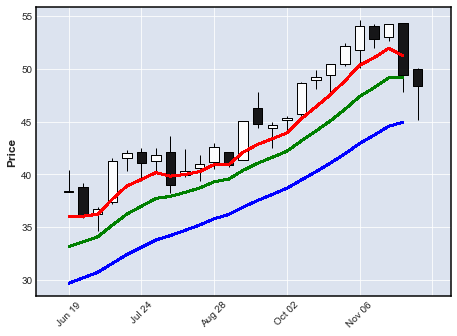

In [15]:
import mplfinance as mpf

def PlotTrade(trade = trade):
    Dates = trades_df['Datetime']

    print("Trade: ", trade)

    selected_df = trades_df[trades_df['trade'] == trade]

    # Get EMAs
    dates = selected_df['Datetime']
    ema6 = selected_df['EMA6']
    ema6 = ema6[:-1]
    ema12 = selected_df['EMA12']
    ema12 = ema12[:-1]
    ema24 = selected_df['EMA24']
    ema24 = ema24[:-1]

    datepairs_ema6 = [(d1, d2) for d1, d2 in zip(dates, ema6)]
    datepairs_ema12 = [(d1, d2) for d1, d2 in zip(dates, ema12)]
    datepairs_ema24 = [(d1, d2) for d1, d2 in zip(dates, ema24)]

    # #Format Dataframe
    quotes = selected_df.iloc[:, :10]
    quotes['Datetime'] = quotes['Datetime'].astype('datetime64')
    quotes = quotes.set_index('Datetime')
    quotes = quotes.iloc[:, :4]
    quotes.columns = ['open', 'high', 'low', 'close']

    # Define function to get entry
    EntryPriceRow = 0


    def GetEntryPriceColl(candle):
        if candle == 'Previous High':
            EntryPriceColl = 1
            EntryPriceRow = 1
        if candle == 'Current Open':
            EntryPriceColl = 0
            EntryPriceRow = 0
        if candle == 'Previous Close':
            EntryPriceColl = 3
            EntryPriceRow = 1
        return EntryPriceColl, EntryPriceRow


    entry_price_column, entry_price_row = GetEntryPriceColl(entry_candle)  #
    # budget = 10000

    entry = selected_df.iloc[window_size-1-entry_price_row, entry_price_column]
    profit = selected_df.iloc[window_size-1, -1]
    real_profit = round((budget / entry)*profit, 2)
    print("\nBudget: ", budget)

    print("\nEntry price: ", round(entry, 2))
    print("Label (target): ", round(selected_df.iloc[window_size-1, 7], 2))
    print("Model prediction: ", round(selected_df.iloc[window_size-1, 8], 2))
    print("\nProfit: {} dollars". format(round(selected_df.iloc[window_size-1, -1], 3)))
    print("Real Profit: " + str(real_profit) +
        " dollars (budget " + str(budget) + ")")


    mpf.plot(quotes, type='candle', alines=dict(alines=[datepairs_ema6, datepairs_ema12, datepairs_ema24], colors=[
            'r', 'g', 'b']))  # datepairs_ema12,datepairs_ema24

    return selected_df
   
df = PlotTrade(trade = trade)
trade += 1
#df


In [16]:
df.head(2)

,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade
In,,,,,,,,,,,,
0,38.352501,40.435001,38.305,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-19,-1.637501,1
1,38.790001,39.150002,35.875,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-26,-1.637501,1


In [18]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle="Current Open",
                        budget=10000,
                        window_size=25,
                        export_excel=True)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final


NameError: name 'budget' is not defined